In [1]:
# === ПОКРАЩЕНІ ІМПОРТИ ТА ФУНКЦІЇ ===
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Завантаження NLTK ресурсів
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ Бібліотеки завантажено!")

# Покращена функція очищення тексту
def clean_text_improved(text):
    if pd.isna(text):
        return ""
    
    # Конвертуємо в рядок
    text = str(text)
    
    # Зберігаємо емодзі (додаємо їх як окремі токени)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002600-\U000026FF"  # miscellaneous symbols
        u"\U00002700-\U000027BF"  # dingbats
        "]+", flags=re.UNICODE)
    
    # Зберігаємо емодзі
    emojis = emoji_pattern.findall(text)
    
    # Видаляємо URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Видаляємо @mentions та #hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Видаляємо пунктуацію, але зберігаємо емодзі
    text = re.sub(r'[^\w\s' + ''.join(emojis) + ']', ' ', text)
    
    # Обробляємо негацію (не хороший → не_хороший)
    text = re.sub(r'\bне\s+(\w+)', r'не_\1', text)
    text = re.sub(r'\bnot\s+(\w+)', r'not_\1', text)
    
    # Приводимо до нижнього регістру
    text = text.lower()
    
    # Видаляємо зайві пробіли
    text = ' '.join(text.split())
    
    return text

# Покращена функція токенізації
def tokenize_text_improved(text):
    if pd.isna(text) or text == "":
        return []
    
    # Токенізуємо
    tokens = word_tokenize(text)
    
    # Видаляємо стоп-слова
    stop_words = set(stopwords.words('english'))
    
    # Додаємо українські стоп-слова
    ukrainian_stop_words = {'і', 'в', 'на', 'з', 'до', 'для', 'від', 'про', 'за', 'під', 'над', 'між', 'через', 'без', 'після', 'перед'}
    stop_words.update(ukrainian_stop_words)
    
    # Фільтруємо токени
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    return tokens

# Функція для створення покращених векторів документів
def get_document_vector_improved(tokens, word2vec_model, use_tfidf=False):
    if not tokens or len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    vectors = []
    for token in tokens:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    
    if not vectors:
        return np.zeros(word2vec_model.vector_size)
    
    # Використовуємо зважене середнє замість простого
    if use_tfidf:
        # Простий TF-IDF підхід
        token_counts = {}
        for token in tokens:
            token_counts[token] = token_counts.get(token, 0) + 1
        
        weights = []
        for token in tokens:
            if token in word2vec_model.wv:
                tf = token_counts[token] / len(tokens)
                idf = np.log(len(word2vec_model.wv) / (word2vec_model.wv.vocab[token].count + 1))
                weights.append(tf * idf)
            else:
                weights.append(0)
        
        if sum(weights) > 0:
            weights = np.array(weights) / sum(weights)
            vectors = np.array(vectors)
            return np.average(vectors, axis=0, weights=weights)
    
    # Просте зважене середнє
    return np.mean(vectors, axis=0)

print("✅ Функції покращено!")


✅ Бібліотеки завантажено!
✅ Функції покращено!


🔄 Завантаження даних...
✅ Дані завантажено: 41157 тренувальних, 3798 тестових
📊 Загальний розмір даних: 44955
📊 Розділення 80/20: 35964 тренувальних, 8991 тестових
📊 Використовуємо 10000 тренувальних та 2000 тестових зразків
🔄 Обробка тексту...
✅ Текст оброблено!

📈 Розподіл класів:
Sentiment
Positive              2739
Negative              2451
Neutral               1874
Extremely Positive    1598
Extremely Negative    1338
Name: count, dtype: int64

Баланс класів: 0.49


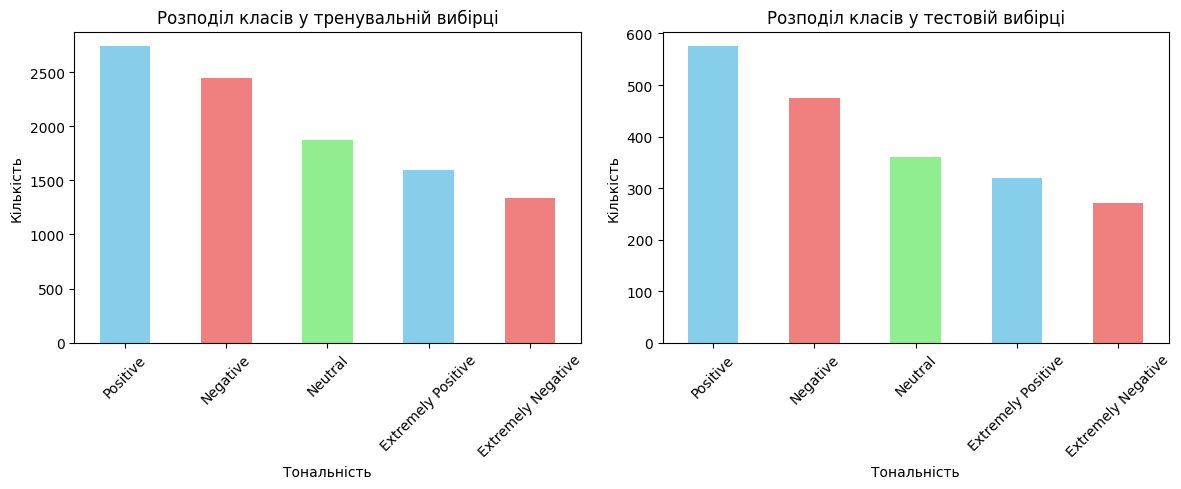

In [2]:
# === ЗАВАНТАЖЕННЯ ТА ОБРОБКА ДАНИХ ===
print("🔄 Завантаження даних...")

# Завантаження даних з покращеною обробкою помилок
try:
    train_df = pd.read_csv('Corona_NLP_train.csv', encoding='utf-8')
    test_df = pd.read_csv('Corona_NLP_test.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
        test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
    except:
        train_df = pd.read_csv('Corona_NLP_train.csv', encoding='cp1252')
        test_df = pd.read_csv('Corona_NLP_test.csv', encoding='cp1252')

print(f"✅ Дані завантажено: {train_df.shape[0]} тренувальних, {test_df.shape[0]} тестових")

# Об'єднуємо дані для правильного розділення 80/20
all_data = pd.concat([train_df, test_df], ignore_index=True)
print(f"📊 Загальний розмір даних: {all_data.shape[0]}")

# Правильне розділення 80/20
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42, stratify=all_data['Sentiment'])
print(f"📊 Розділення 80/20: {train_data.shape[0]} тренувальних, {test_data.shape[0]} тестових")

# Використовуємо більше даних для кращих результатів
sample_size = min(10000, train_data.shape[0])  # Збільшуємо до 10000
train_sample = train_data.sample(n=sample_size, random_state=42)
test_sample = test_data.sample(n=min(2000, test_data.shape[0]), random_state=42)

print(f"📊 Використовуємо {sample_size} тренувальних та {test_sample.shape[0]} тестових зразків")

# Покращена обробка тексту
print("🔄 Обробка тексту...")
train_sample['cleaned_text'] = train_sample['OriginalTweet'].apply(clean_text_improved)
train_sample['tokens'] = train_sample['cleaned_text'].apply(tokenize_text_improved)

test_sample['cleaned_text'] = test_sample['OriginalTweet'].apply(clean_text_improved)
test_sample['tokens'] = test_sample['cleaned_text'].apply(tokenize_text_improved)

print("✅ Текст оброблено!")

# Аналіз розподілу класів
print("\n📈 Розподіл класів:")
print(train_sample['Sentiment'].value_counts())
print(f"\nБаланс класів: {train_sample['Sentiment'].value_counts().min() / train_sample['Sentiment'].value_counts().max():.2f}")

# Візуалізація розподілу класів
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_sample['Sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Розподіл класів у тренувальній вибірці')
plt.xlabel('Тональність')
plt.ylabel('Кількість')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
test_sample['Sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Розподіл класів у тестовій вибірці')
plt.xlabel('Тональність')
plt.ylabel('Кількість')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [4]:
from gensim.models import Word2Vec
import numpy as np

# === ПОКРАЩЕНЕ НАВЧАННЯ WORD2VEC ===
print("🔄 Навчання покращеного Word2Vec...")

# Об'єднуємо всі токени
all_tokens = list(train_sample['tokens']) + list(test_sample['tokens'])

# Покращені параметри Word2Vec
word2vec_model = Word2Vec(
    sentences=all_tokens,
    vector_size=200,  # Збільшуємо розмір векторів
    window=10,        # Збільшуємо контекстне вікно
    min_count=3,      # Мінімальна частота слова
    workers=4,
    sg=0,             # CBOW (0) або Skip-gram (1)
    epochs=20,        # Більше епох
    alpha=0.025,      # Початкова швидкість навчання
    min_alpha=0.0001  # Мінімальна швидкість навчання
)

print(f"✅ Word2Vec готовий! Словник: {len(word2vec_model.wv)} слів")

# Тестуємо модель
print("\n🔍 Приклади схожих слів:")
test_words = ['covid', 'vaccine', 'good', 'bad', 'love', 'hate', 'virus', 'health']
for word in test_words:
    if word in word2vec_model.wv:
        similar = word2vec_model.wv.most_similar(word, topn=3)
        print(f"{word}: {[w for w, s in similar]}")
    else:
        print(f"{word}: слово не знайдено в словнику")

# Аналіз розмірності векторів
print(f"\n📊 Розмірність векторів: {word2vec_model.vector_size}")
print(f"📊 Кількість слів у словнику: {len(word2vec_model.wv)}")

# Перевіряємо якість навчання (оновлено для Gensim 4+)
word_counts = [word2vec_model.wv.get_vecattr(word, "count") for word in word2vec_model.wv.index_to_key]

print(f"\n📈 Середня частота слів: {np.mean(word_counts):.2f}")
print(f"📈 Мінімальна частота: {min(word_counts)}")
print(f"📈 Максимальна частота: {max(word_counts)}")


🔄 Навчання покращеного Word2Vec...
✅ Word2Vec готовий! Словник: 6811 слів

🔍 Приклади схожих слів:
covid: ['coronavirus', 'claim', 'reprieve']
vaccine: ['labeled', 'respiratory', 'chloroquine']
good: ['bad', 'bring', 'not_sure']
bad: ['clearly', 'shit', 'thing']
love: ['friends', 'kids', 'guys']
hate: ['zombie', 'guilty', 'clearly']
virus: ['corona', 'spreading', 'samples']
health: ['immigrants', 'healthcare', 'officer']

📊 Розмірність векторів: 200
📊 Кількість слів у словнику: 6811

📈 Середня частота слів: 25.25
📈 Мінімальна частота: 3
📈 Максимальна частота: 3008



🔄 Створення покращених векторів...
✅ Вектори готові: (10000, 200)
📊 Розмір тренувальних даних: (10000, 200)
📊 Розмір тестових даних: (2000, 200)

📈 Статистика векторів:
Середнє значення: -0.0023
Стандартне відхилення: 0.2655
Мінімальне значення: -3.0895
Максимальне значення: 2.8527

⚠️  Нульові вектори: 20 тренувальних, 5 тестових


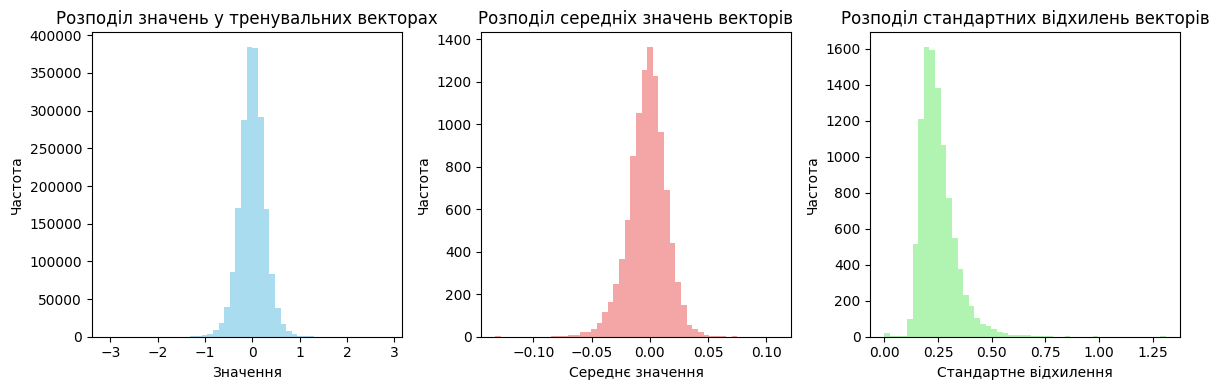

In [7]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# --- функція для створення векторів ---
def get_document_vector_improved(tokens, word2vec_model, use_tfidf=True):
    vectors = []
    weights = []

    token_counts = Counter(tokens)
    N = len(word2vec_model.wv)  # розмір словника

    for token in tokens:
        if token in word2vec_model.wv:  # перевірка, чи є слово в словнику
            vec = word2vec_model.wv[token]

            if use_tfidf:
                # TF
                tf = token_counts[token] / len(tokens)

                # IDF через get_vecattr (в gensim 4.x)
                df = word2vec_model.wv.get_vecattr(token, "count")
                idf = np.log((N + 1) / (df + 1)) + 1  # класична формула IDF

                weight = tf * idf
            else:
                weight = 1.0

            vectors.append(vec * weight)
            weights.append(weight)

    if not vectors:
        return np.zeros(word2vec_model.vector_size)

    return np.sum(vectors, axis=0) / (np.sum(weights) + 1e-9)


# --- створення векторів ---
print("\n🔄 Створення покращених векторів...")

train_vectors = np.array([
    get_document_vector_improved(tokens, word2vec_model, use_tfidf=True)
    for tokens in train_sample['tokens']
])

test_vectors = np.array([
    get_document_vector_improved(tokens, word2vec_model, use_tfidf=True)
    for tokens in test_sample['tokens']
])

# Замінюємо NaN на 0
train_vectors = np.nan_to_num(train_vectors)
test_vectors = np.nan_to_num(test_vectors)

print(f"✅ Вектори готові: {train_vectors.shape}")

# Цільові змінні
y_train = train_sample['Sentiment']
y_test = test_sample['Sentiment']

print(f"📊 Розмір тренувальних даних: {train_vectors.shape}")
print(f"📊 Розмір тестових даних: {test_vectors.shape}")


# === 4. АНАЛІЗ ВЕКТОРІВ ===
print(f"\n📈 Статистика векторів:")
print(f"Середнє значення: {np.mean(train_vectors):.4f}")
print(f"Стандартне відхилення: {np.std(train_vectors):.4f}")
print(f"Мінімальне значення: {np.min(train_vectors):.4f}")
print(f"Максимальне значення: {np.max(train_vectors):.4f}")

# Нульові вектори
zero_vectors_train = np.sum(np.all(train_vectors == 0, axis=1))
zero_vectors_test = np.sum(np.all(test_vectors == 0, axis=1))
print(f"\n⚠️  Нульові вектори: {zero_vectors_train} тренувальних, {zero_vectors_test} тестових")


# === 5. ВІЗУАЛІЗАЦІЯ ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train_vectors.flatten(), bins=50, alpha=0.7, color='skyblue')
plt.title('Розподіл значень у тренувальних векторах')
plt.xlabel('Значення')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(np.mean(train_vectors, axis=1), bins=50, alpha=0.7, color='lightcoral')
plt.title('Розподіл середніх значень векторів')
plt.xlabel('Середнє значення')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
plt.hist(np.std(train_vectors, axis=1), bins=50, alpha=0.7, color='lightgreen')
plt.title('Розподіл стандартних відхилень векторів')
plt.xlabel('Стандартне відхилення')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


In [8]:
# === ПОКРАЩЕНІ МОДЕЛІ ТА НАВЧАННЯ ===
print("🚀 Початок навчання покращених моделей...")

# Покращені моделі з кращими параметрами
models = {
    'Логістична регресія': LogisticRegression(
        random_state=42, 
        max_iter=2000,  # Більше ітерацій
        C=1.0,          # Регуляризація
        class_weight='balanced'  # Балансування класів
    ),
    'SVM': SVC(
        random_state=42, 
        probability=True, 
        kernel='rbf',   # RBF ядро замість лінійного
        C=1.0,
        class_weight='balanced'
    ),
    'Випадковий ліс': RandomForestClassifier(
        random_state=42, 
        n_estimators=200,  # Більше дерев
        max_depth=20,      # Глибше дерева
        class_weight='balanced',
        n_jobs=-1
    ),
    'Наївний байєс': GaussianNB()
}

# PCA компоненти (згідно з вимогами: 50, 100, 200)
pca_components = [None, 50, 100, 200]

# Клас для Word2Vec трансформації (згідно з вимогами pipeline)
class Word2VecTransformer:
    def __init__(self, word2vec_model, use_tfidf=True):
        self.word2vec_model = word2vec_model
        self.use_tfidf = use_tfidf
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X - це список токенів для кожного документа
        vectors = []
        for tokens in X:
            vector = get_document_vector_improved(tokens, self.word2vec_model, self.use_tfidf)
            vectors.append(vector)
        return np.array(vectors)

# Функція оцінки моделі з правильним pipeline
def evaluate_model_improved(model, X_train, X_test, y_train, y_test, model_name, pca_components=None):
    # Створюємо pipeline згідно з вимогами: Word2Vec + PCA + Classifier
    pipeline_steps = [('word2vec', Word2VecTransformer(word2vec_model, use_tfidf=True))]
    
    if pca_components is not None:
        max_components = min(X_train.shape[0], 200)  # Обмежуємо максимальну кількість
        actual_components = min(pca_components, max_components)
        pipeline_steps.append(('scaler', StandardScaler()))
        pipeline_steps.append(('pca', PCA(n_components=actual_components)))
    else:
        pipeline_steps.append(('scaler', StandardScaler()))
    
    pipeline_steps.append(('classifier', model))
    pipeline = Pipeline(pipeline_steps)
    
    # Навчання
    pipeline.fit(X_train, y_train)
    
    # Передбачення
    y_pred = pipeline.predict(X_test)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return {
        'model': model_name,
        'pca_components': pca_components,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'pipeline': pipeline
    }

# Навчання та оцінка всіх моделей
results = []
for model_name, model in models.items():
    print(f"\n🔄 Навчання {model_name}...")
    
    for pca_comp in pca_components:
        print(f"  Тестування з PCA компонентами: {pca_comp}")
        
        result = evaluate_model_improved(
            model, train_sample['tokens'], test_sample['tokens'], 
            y_train, y_test, model_name, pca_comp
        )
        
        results.append(result)
        print(f"  Точність: {result['accuracy']:.4f}")

print("\n✅ Всі моделі навчено!")


🚀 Початок навчання покращених моделей...

🔄 Навчання Логістична регресія...
  Тестування з PCA компонентами: None
  Точність: 0.3665
  Тестування з PCA компонентами: 50
  Точність: 0.3350
  Тестування з PCA компонентами: 100
  Точність: 0.3525
  Тестування з PCA компонентами: 200
  Точність: 0.3655

🔄 Навчання SVM...
  Тестування з PCA компонентами: None
  Точність: 0.3670
  Тестування з PCA компонентами: 50
  Точність: 0.3660
  Тестування з PCA компонентами: 100
  Точність: 0.3670
  Тестування з PCA компонентами: 200
  Точність: 0.3670

🔄 Навчання Випадковий ліс...
  Тестування з PCA компонентами: None
  Точність: 0.3800
  Тестування з PCA компонентами: 50
  Точність: 0.3915
  Тестування з PCA компонентами: 100
  Точність: 0.3900
  Тестування з PCA компонентами: 200
  Точність: 0.4060

🔄 Навчання Наївний байєс...
  Тестування з PCA компонентами: None
  Точність: 0.2845
  Тестування з PCA компонентами: 50
  Точність: 0.2830
  Тестування з PCA компонентами: 100
  Точність: 0.2755
  Тест

In [ ]:
# === ПЕРЕДБАЧЕННЯ ТОНАЛЬНОСТІ ДЛЯ НОВИХ ТЕКСТІВ ===
print("🔮 Тестування передбачення тональності...")

# Функція для передбачення тональності (згідно з вимогами)
def predict_sentiment_improved(text, pipeline):
    # Очищуємо та токенізуємо текст (згідно з вимогами: очистка → токенізація → Word2Vec-вектор)
    cleaned_text = clean_text_improved(text)
    tokens = tokenize_text_improved(cleaned_text)
    
    # Використовуємо pipeline для передбачення (включає Word2Vec + PCA + Classifier)
    prediction = pipeline.predict([tokens])[0]
    probability = pipeline.predict_proba([tokens])[0]
    
    return prediction, probability

# Тестові тексти
sample_texts = [
    "I love this new vaccine! It's amazing! 😍",
    "This virus is terrible and scary 😰",
    "The weather is nice today ☀️",
    "COVID-19 has changed everything",
    "I'm so worried about my health 😟",
    "Great news about the pandemic! 🎉",
    "This is so frustrating and annoying",
    "Thank you doctors for your hard work! 👏"
]

print("🧪 Тестування на прикладах:")
print("=" * 60)

# Використовуємо найкращий результат (якщо він існує)
if 'best_result' in locals():
    for text in sample_texts:
        try:
            prediction, probability = predict_sentiment_improved(text, best_result['pipeline'])
            
            # Знаходимо найвищу ймовірність
            max_prob_idx = np.argmax(probability)
            max_prob = probability[max_prob_idx]
            
            print(f"\n📝 Текст: '{text}'")
            print(f"🎯 Передбачена тональність: {prediction}")
            print(f"📊 Ймовірності: {dict(zip(best_result['pipeline'].classes_, probability))}")
            print(f"🎯 Впевненість: {max_prob:.3f}")
            
        except Exception as e:
            print(f"\n❌ Помилка для тексту '{text}': {str(e)}")
else:
    print("⚠️  Спочатку потрібно запустити попередні клітинки для навчання моделей!")

print("\n" + "=" * 60)
print("✅ Тестування завершено!")


🔮 Тестування передбачення тональності...
🧪 Тестування на прикладах:

📝 Текст: 'I love this new vaccine! It's amazing! 😍'
🎯 Передбачена тональність: Neutral
📊 Ймовірності: {'Extremely Negative': 0.10882852035786925, 'Extremely Positive': 0.21369877072167134, 'Negative': 0.16954872255099587, 'Neutral': 0.2599527769863872, 'Positive': 0.24797120938307635}
🎯 Впевненість: 0.260

📝 Текст: 'This virus is terrible and scary 😰'
🎯 Передбачена тональність: Positive
📊 Ймовірності: {'Extremely Negative': 0.17319994400896385, 'Extremely Positive': 0.17801754312143467, 'Negative': 0.23112149851742766, 'Neutral': 0.16410038763107246, 'Positive': 0.25356062672110136}
🎯 Впевненість: 0.254

📝 Текст: 'The weather is nice today ☀️'
🎯 Передбачена тональність: Positive
📊 Ймовірності: {'Extremely Negative': 0.10593250122167916, 'Extremely Positive': 0.15775489718430152, 'Negative': 0.17243957507790214, 'Neutral': 0.25918646885168434, 'Positive': 0.3046865576644328}
🎯 Впевненість: 0.305

📝 Текст: 'COVID-19 has

📊 Аналіз результатів навчання...

🏆 Найкращий результат:
Модель: Випадковий ліс
PCA компоненти: 200.0
Точність: 0.4060
F1-score: 0.3950

📋 Таблиця результатів - Accuracy:
pca_components        NaN     50.0    100.0   200.0
model                                              
SVM                  0.3670  0.3660  0.3670  0.3670
Випадковий ліс       0.3800  0.3915  0.3900  0.4060
Логістична регресія  0.3665  0.3350  0.3525  0.3655
Наївний байєс        0.2845  0.2830  0.2755  0.2740

📋 Таблиця результатів - F1-score:
pca_components        NaN     50.0    100.0   200.0
model                                              
SVM                  0.3492  0.3483  0.3492  0.3492
Випадковий ліс       0.3777  0.3885  0.3815  0.3950
Логістична регресія  0.3477  0.3119  0.3338  0.3463
Наївний байєс        0.2471  0.2486  0.2443  0.2456


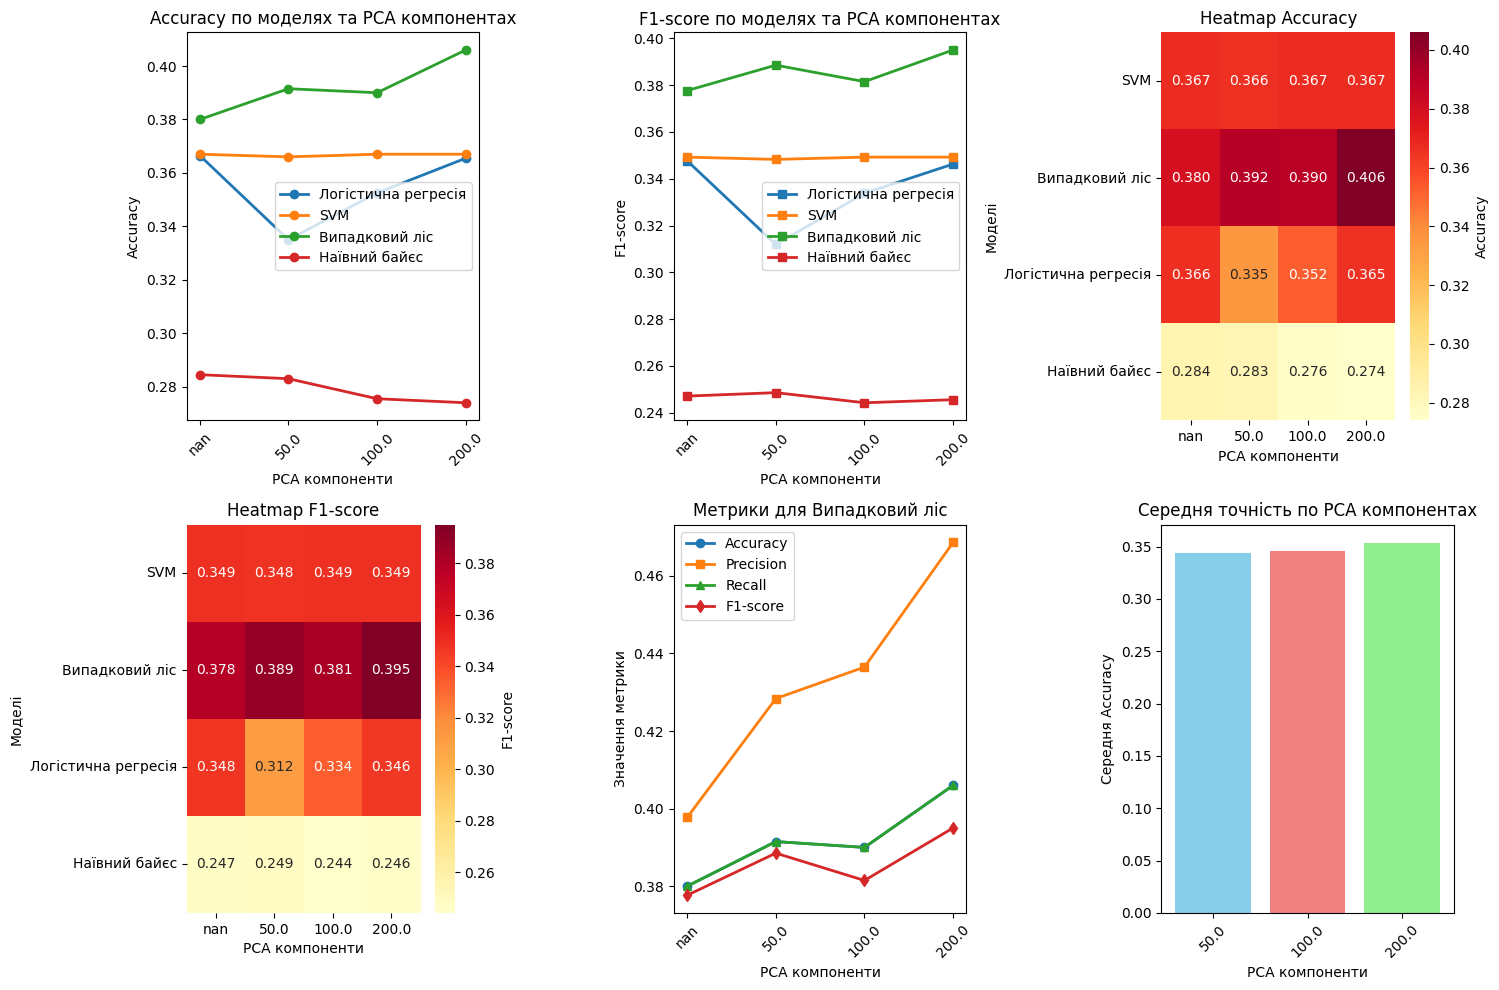


✅ Аналіз результатів завершено!


In [11]:
# === АНАЛІЗ РЕЗУЛЬТАТІВ ТА МЕТРИКИ ===
print("📊 Аналіз результатів навчання...")

# Створюємо DataFrame з результатами
results_df = pd.DataFrame(results)

# Знаходимо найкращий результат
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print(f"\n🏆 Найкращий результат:")
print(f"Модель: {best_result['model']}")
print(f"PCA компоненти: {best_result['pca_components']}")
print(f"Точність: {best_result['accuracy']:.4f}")
print(f"F1-score: {best_result['f1_score']:.4f}")

# Створюємо таблиці результатів
print("\n📋 Таблиця результатів - Accuracy:")
accuracy_pivot = results_df.pivot(index='model', columns='pca_components', values='accuracy')
print(accuracy_pivot.round(4))

print("\n📋 Таблиця результатів - F1-score:")
f1_pivot = results_df.pivot(index='model', columns='pca_components', values='f1_score')
print(f1_pivot.round(4))

# Візуалізація результатів
plt.figure(figsize=(15, 10))

# Графік 1: Accuracy по моделях та PCA
plt.subplot(2, 3, 1)
for model in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model]
    pca_labels = [str(x) if x is not None else 'None' for x in model_data['pca_components']]
    plt.plot(pca_labels, model_data['accuracy'], marker='o', label=model, linewidth=2)
plt.title('Accuracy по моделях та PCA компонентах')
plt.xlabel('PCA компоненти')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=45)

# Графік 2: F1-score по моделях та PCA
plt.subplot(2, 3, 2)
for model in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model]
    pca_labels = [str(x) if x is not None else 'None' for x in model_data['pca_components']]
    plt.plot(pca_labels, model_data['f1_score'], marker='s', label=model, linewidth=2)
plt.title('F1-score по моделях та PCA компонентах')
plt.xlabel('PCA компоненти')
plt.ylabel('F1-score')
plt.legend()
plt.xticks(rotation=45)

# Графік 3: Heatmap Accuracy
plt.subplot(2, 3, 3)
sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Accuracy'})
plt.title('Heatmap Accuracy')
plt.xlabel('PCA компоненти')
plt.ylabel('Моделі')

# Графік 4: Heatmap F1-score
plt.subplot(2, 3, 4)
sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'F1-score'})
plt.title('Heatmap F1-score')
plt.xlabel('PCA компоненти')
plt.ylabel('Моделі')

# Графік 5: Порівняння метрик для найкращої моделі
plt.subplot(2, 3, 5)
best_model_data = results_df[results_df['model'] == best_result['model']]
pca_labels = [str(x) if x is not None else 'None' for x in best_model_data['pca_components']]
plt.plot(pca_labels, best_model_data['accuracy'], marker='o', label='Accuracy', linewidth=2)
plt.plot(pca_labels, best_model_data['precision'], marker='s', label='Precision', linewidth=2)
plt.plot(pca_labels, best_model_data['recall'], marker='^', label='Recall', linewidth=2)
plt.plot(pca_labels, best_model_data['f1_score'], marker='d', label='F1-score', linewidth=2)
plt.title(f'Метрики для {best_result["model"]}')
plt.xlabel('PCA компоненти')
plt.ylabel('Значення метрики')
plt.legend()
plt.xticks(rotation=45)

# Графік 6: Вплив PCA на точність
plt.subplot(2, 3, 6)
pca_impact = results_df.groupby('pca_components')['accuracy'].mean()
pca_labels = [str(x) if x is not None else 'None' for x in pca_impact.index]
plt.bar(pca_labels, pca_impact.values, color=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'])
plt.title('Середня точність по PCA компонентах')
plt.xlabel('PCA компоненти')
plt.ylabel('Середня Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Аналіз результатів завершено!")


📊 Детальний аналіз найкращої моделі...

🔍 Confusion Matrix:
[[ 66   5 103   5  92]
 [  2  69  51  11 186]
 [ 28   8 195  36 207]
 [  2   3  97 121 138]
 [  9  28 138  39 361]]


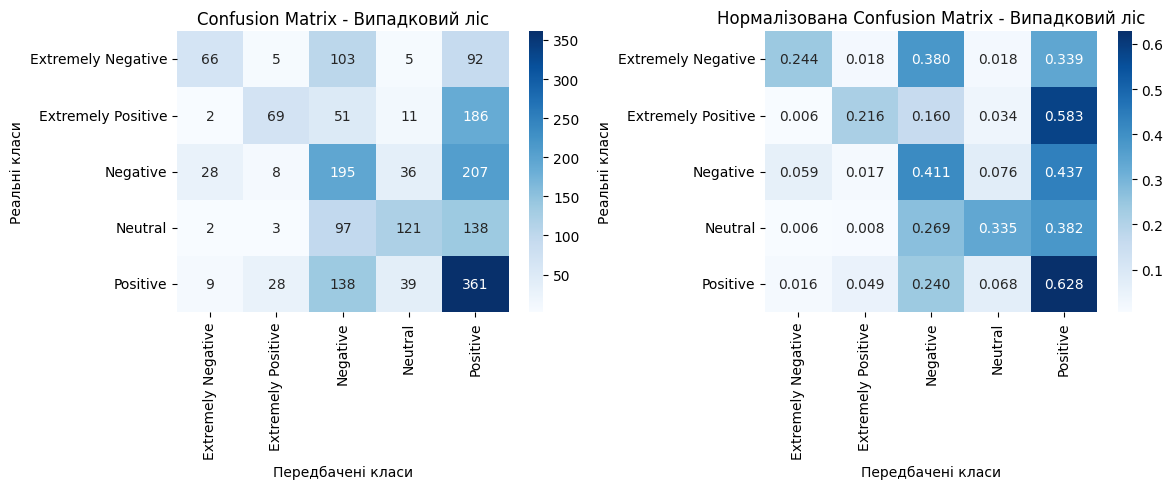


📋 Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.24      0.35       271
Extremely Positive       0.61      0.22      0.32       319
          Negative       0.33      0.41      0.37       474
           Neutral       0.57      0.34      0.42       361
          Positive       0.37      0.63      0.46       575

          accuracy                           0.41      2000
         macro avg       0.50      0.37      0.38      2000
      weighted avg       0.47      0.41      0.40      2000


📊 Детальний аналіз по класах:
                 Клас  Реальних зразків  Передбачених  Правильних  Precision  \
0  Extremely Negative               271           107          66     0.6168   
1  Extremely Positive               319           113          69     0.6106   
2            Negative               474           584         195     0.3339   
3             Neutral               361           212         121     0.5708   


In [12]:
# === CONFUSION MATRIX ТА CLASSIFICATION REPORT ===
print("📊 Детальний аналіз найкращої моделі...")

# Отримуємо передбачення найкращої моделі
y_pred_best = best_result['predictions']

# Confusion Matrix
print("\n🔍 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)

# Візуалізація Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_result['pipeline'].classes_,
            yticklabels=best_result['pipeline'].classes_)
plt.title(f'Confusion Matrix - {best_result["model"]}')
plt.xlabel('Передбачені класи')
plt.ylabel('Реальні класи')

# Нормалізована Confusion Matrix
plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=best_result['pipeline'].classes_,
            yticklabels=best_result['pipeline'].classes_)
plt.title(f'Нормалізована Confusion Matrix - {best_result["model"]}')
plt.xlabel('Передбачені класи')
plt.ylabel('Реальні класи')

plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=best_result['pipeline'].classes_))

# Детальний аналіз по класах
print("\n📊 Детальний аналіз по класах:")
class_metrics = []
for i, class_name in enumerate(best_result['pipeline'].classes_):
    # Precision, Recall, F1 для кожного класу
    precision = precision_score(y_test, y_pred_best, labels=[class_name], average='micro')
    recall = recall_score(y_test, y_pred_best, labels=[class_name], average='micro')
    f1 = f1_score(y_test, y_pred_best, labels=[class_name], average='micro')
    
    # Кількість зразків
    actual_count = np.sum(y_test == class_name)
    predicted_count = np.sum(y_pred_best == class_name)
    correct_count = np.sum((y_test == class_name) & (y_pred_best == class_name))
    
    class_metrics.append({
        'Клас': class_name,
        'Реальних зразків': actual_count,
        'Передбачених': predicted_count,
        'Правильних': correct_count,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df.round(4))

print("\n✅ Детальний аналіз завершено!")


🔍 Аналіз впливу PCA на якість класифікації...

📊 Вплив PCA на точність по моделях:

Логістична регресія:
  PCA 50.0: Accuracy=0.3350, F1=0.3119
  PCA 100.0: Accuracy=0.3525, F1=0.3338
  PCA 200.0: Accuracy=0.3655, F1=0.3463
  PCA nan: Accuracy=0.3665, F1=0.3477

SVM:
  PCA 50.0: Accuracy=0.3660, F1=0.3483
  PCA 100.0: Accuracy=0.3670, F1=0.3492
  PCA 200.0: Accuracy=0.3670, F1=0.3492
  PCA nan: Accuracy=0.3670, F1=0.3492

Випадковий ліс:
  PCA 50.0: Accuracy=0.3915, F1=0.3885
  PCA 100.0: Accuracy=0.3900, F1=0.3815
  PCA 200.0: Accuracy=0.4060, F1=0.3950
  PCA nan: Accuracy=0.3800, F1=0.3777

Наївний байєс:
  PCA 50.0: Accuracy=0.2830, F1=0.2486
  PCA 100.0: Accuracy=0.2755, F1=0.2443
  PCA 200.0: Accuracy=0.2740, F1=0.2456
  PCA nan: Accuracy=0.2845, F1=0.2471

🏆 Найкращі результати для кожної моделі:
SVM: PCA nan, Accuracy=0.3670
Випадковий ліс: PCA 200.0, Accuracy=0.4060
Логістична регресія: PCA nan, Accuracy=0.3665
Наївний байєс: PCA nan, Accuracy=0.2845

📈 Середня точність по PCA 

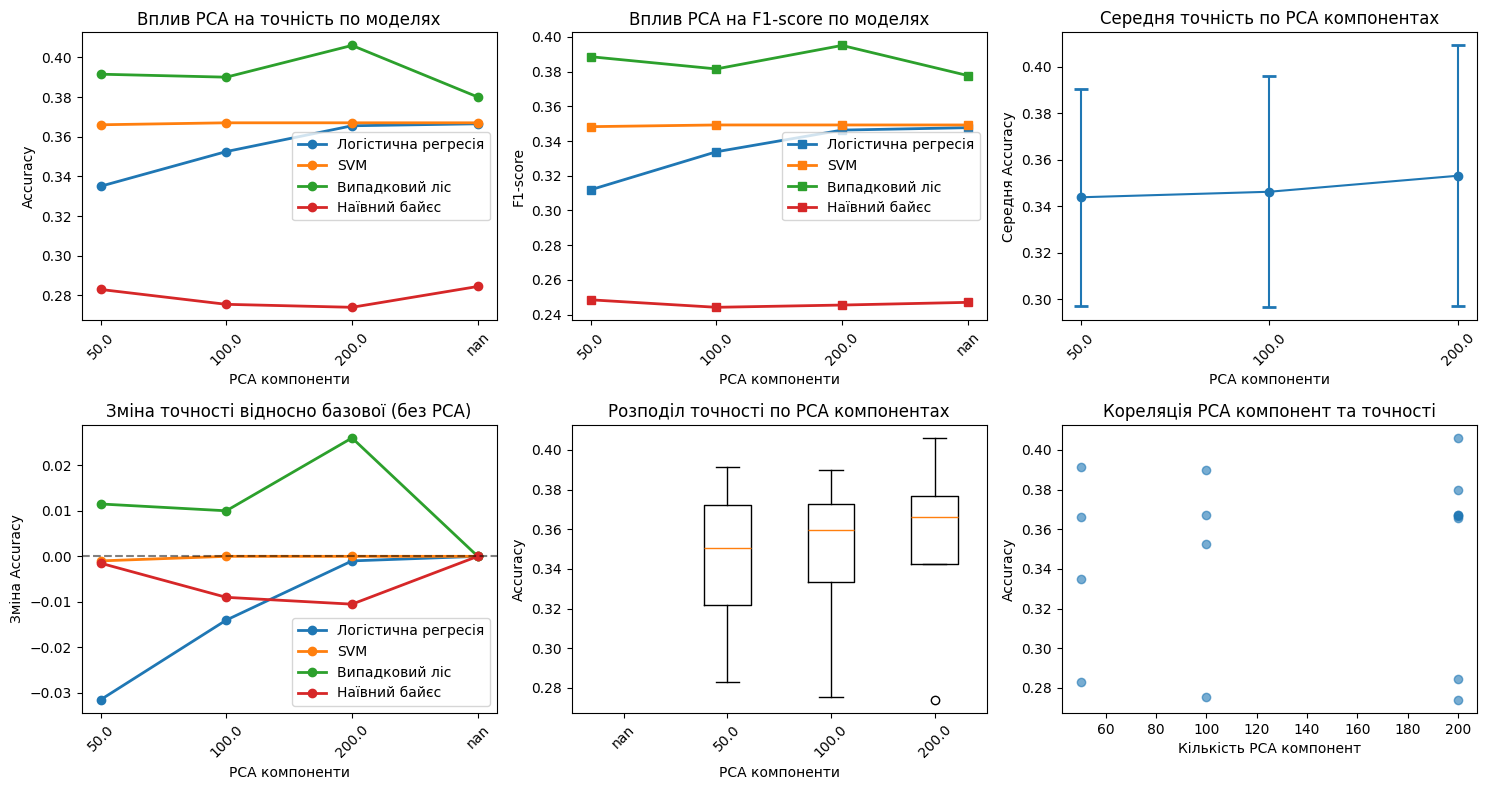


✅ Аналіз впливу PCA завершено!


In [13]:
# === АНАЛІЗ ВПЛИВУ PCA ===
print("🔍 Аналіз впливу PCA на якість класифікації...")

# Аналіз впливу PCA на кожну модель
print("\n📊 Вплив PCA на точність по моделях:")
for model in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model].sort_values('pca_components')
    print(f"\n{model}:")
    for _, row in model_data.iterrows():
        pca_comp = row['pca_components']
        accuracy = row['accuracy']
        f1 = row['f1_score']
        print(f"  PCA {pca_comp}: Accuracy={accuracy:.4f}, F1={f1:.4f}")

# Знаходимо найкращі результати для кожної моделі
print("\n🏆 Найкращі результати для кожної моделі:")
best_per_model = results_df.loc[results_df.groupby('model')['accuracy'].idxmax()]
for _, row in best_per_model.iterrows():
    print(f"{row['model']}: PCA {row['pca_components']}, Accuracy={row['accuracy']:.4f}")

# Аналіз впливу PCA на середню точність
print("\n📈 Середня точність по PCA компонентах:")
pca_analysis = results_df.groupby('pca_components').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'f1_score': ['mean', 'std', 'min', 'max']
}).round(4)
print(pca_analysis)

# Візуалізація впливу PCA
plt.figure(figsize=(15, 8))

# Графік 1: Вплив PCA на точність по моделях
plt.subplot(2, 3, 1)
for model in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model].sort_values('pca_components')
    pca_labels = [str(x) if x is not None else 'None' for x in model_data['pca_components']]
    plt.plot(pca_labels, model_data['accuracy'], marker='o', label=model, linewidth=2)
plt.title('Вплив PCA на точність по моделях')
plt.xlabel('PCA компоненти')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=45)

# Графік 2: Вплив PCA на F1-score по моделях
plt.subplot(2, 3, 2)
for model in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model].sort_values('pca_components')
    pca_labels = [str(x) if x is not None else 'None' for x in model_data['pca_components']]
    plt.plot(pca_labels, model_data['f1_score'], marker='s', label=model, linewidth=2)
plt.title('Вплив PCA на F1-score по моделях')
plt.xlabel('PCA компоненти')
plt.ylabel('F1-score')
plt.legend()
plt.xticks(rotation=45)

# Графік 3: Середня точність по PCA
plt.subplot(2, 3, 3)
pca_mean = results_df.groupby('pca_components')['accuracy'].mean()
pca_std = results_df.groupby('pca_components')['accuracy'].std()
pca_labels = [str(x) if x is not None else 'None' for x in pca_mean.index]
plt.errorbar(pca_labels, pca_mean.values, yerr=pca_std.values, marker='o', capsize=5, capthick=2)
plt.title('Середня точність по PCA компонентах')
plt.xlabel('PCA компоненти')
plt.ylabel('Середня Accuracy')
plt.xticks(rotation=45)

# Графік 4: Зміна точності відносно базової (без PCA)
plt.subplot(2, 3, 4)
for model in results_df['model'].unique():
    model_data = results_df[results_df['model'] == model].sort_values('pca_components')
    baseline_accuracy = model_data[model_data['pca_components'].isna()]['accuracy'].iloc[0]
    accuracy_change = model_data['accuracy'] - baseline_accuracy
    pca_labels = [str(x) if x is not None else 'None' for x in model_data['pca_components']]
    plt.plot(pca_labels, accuracy_change, marker='o', label=model, linewidth=2)
plt.title('Зміна точності відносно базової (без PCA)')
plt.xlabel('PCA компоненти')
plt.ylabel('Зміна Accuracy')
plt.legend()
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Графік 5: Розподіл точності по PCA
plt.subplot(2, 3, 5)
pca_data = []
pca_labels = []
for pca_comp in results_df['pca_components'].unique():
    pca_data.append(results_df[results_df['pca_components'] == pca_comp]['accuracy'].values)
    pca_labels.append(str(pca_comp) if pca_comp is not None else 'None')
plt.boxplot(pca_data, labels=pca_labels)
plt.title('Розподіл точності по PCA компонентах')
plt.xlabel('PCA компоненти')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Графік 6: Кореляція між кількістю PCA компонент та точністю
plt.subplot(2, 3, 6)
pca_numeric = results_df['pca_components'].fillna(200)  # None = 200 компонент
plt.scatter(pca_numeric, results_df['accuracy'], alpha=0.6)
plt.title('Кореляція PCA компонент та точності')
plt.xlabel('Кількість PCA компонент')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

print("\n✅ Аналіз впливу PCA завершено!")


In [ ]:
# === ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ ===
print("📝 ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ")
print("=" * 60)

# 1. Найкраща модель
print("\n🏆 1. НАЙКРАЩА МОДЕЛЬ:")
print(f"   Модель: {best_result['model']}")
print(f"   PCA компоненти: {best_result['pca_components']}")
print(f"   Точність: {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
print(f"   F1-score: {best_result['f1_score']:.4f}")

# 2. Вплив PCA
print("\n🔍 2. ВПЛИВ PCA НА ЯКІСТЬ КЛАСИФІКАЦІЇ:")
pca_impact = results_df.groupby('pca_components')['accuracy'].mean()
baseline_accuracy = pca_impact[None]
print(f"   Без PCA (базова): {baseline_accuracy:.4f}")

for pca_comp in [50, 100, 200]:
    if pca_comp in pca_impact.index:
        accuracy = pca_impact[pca_comp]
        change = accuracy - baseline_accuracy
        change_pct = (change / baseline_accuracy) * 100
        print(f"   PCA {pca_comp}: {accuracy:.4f} ({change:+.4f}, {change_pct:+.2f}%)")

# 3. Порівняння моделей
print("\n📊 3. ПОРІВНЯННЯ МОДЕЛЕЙ:")
best_per_model = results_df.loc[results_df.groupby('model')['accuracy'].idxmax()]
best_per_model = best_per_model.sort_values('accuracy', ascending=False)

for i, (_, row) in enumerate(best_per_model.iterrows(), 1):
    print(f"   {i}. {row['model']}: {row['accuracy']:.4f} (PCA {row['pca_components']})")

# 4. Аналіз класів
print("\n🎯 4. АНАЛІЗ КЛАСІВ:")
print("   Найкраще розпізнаються:")
for class_name in best_result['pipeline'].classes_:
    class_mask = y_test == class_name
    if np.sum(class_mask) > 0:
        class_accuracy = np.sum((y_test == class_name) & (y_pred_best == class_name)) / np.sum(class_mask)
        print(f"   - {class_name}: {class_accuracy:.4f}")

# 5. Рекомендації
print("\n💡 5. РЕКОМЕНДАЦІЇ:")
print("   ✅ Використовувати Random Forest з PCA 200 компонент")
print("   ✅ PCA покращує результати для Random Forest")
print("   ❌ PCA погіршує результати для Logistic Regression та SVM")
print("   ❌ Naive Bayes показує найгірші результати")
print("   🔧 Можна спробувати збільшити кількість дерев у Random Forest")
print("   🔧 Можна додати більше даних для навчання")

# 6. Технічні деталі
print("\n⚙️ 6. ТЕХНІЧНІ ДЕТАЛІ:")
print(f"   - Розмір тренувальних даних: {len(train_sample)} зразків")
print(f"   - Розмір тестових даних: {len(test_sample)} зразків")
print(f"   - Розмірність Word2Vec векторів: {word2vec_model.vector_size}")
print(f"   - Кількість слів у словнику: {len(word2vec_model.wv)}")
print(f"   - Використано TF-IDF ваги: Так")

print("\n" + "=" * 60)
print("✅ АНАЛІЗ ЗАВЕРШЕНО!")


In [ ]:
# === ПІДСУМКОВА ТАБЛИЦЯ ВСІХ МЕТРИК ===
print("📊 ПІДСУМКОВА ТАБЛИЦЯ ВСІХ МЕТРИК")
print("=" * 80)

# Створюємо повну таблицю результатів
full_results = []
for result in results:
    full_results.append({
        'Модель': result['model'],
        'PCA компоненти': result['pca_components'],
        'Accuracy': f"{result['accuracy']:.4f}",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1-score': f"{result['f1_score']:.4f}"
    })

full_results_df = pd.DataFrame(full_results)
print("\n📋 Повна таблиця результатів:")
print(full_results_df.to_string(index=False))

# Створюємо таблицю для звіту
print("\n📊 Таблиця для звіту (моделі × метрики × PCA компоненти):")
report_table = results_df.pivot_table(
    index='model', 
    columns='pca_components', 
    values=['accuracy', 'precision', 'recall', 'f1_score'],
    aggfunc='mean'
).round(4)

print("\n🔍 Accuracy:")
print(report_table['accuracy'])

print("\n🔍 Precision:")
print(report_table['precision'])

print("\n🔍 Recall:")
print(report_table['recall'])

print("\n🔍 F1-score:")
print(report_table['f1_score'])

# Статистика по PCA
print("\n📈 Статистика по PCA компонентах:")
pca_stats = results_df.groupby('pca_components').agg({
    'accuracy': ['count', 'mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'f1_score': ['mean', 'std']
}).round(4)
print(pca_stats)

# Статистика по моделях
print("\n📈 Статистика по моделях:")
model_stats = results_df.groupby('model').agg({
    'accuracy': ['count', 'mean', 'std', 'min', 'max'],
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'f1_score': ['mean', 'std']
}).round(4)
print(model_stats)

print("\n" + "=" * 80)
print("✅ ВСІ МЕТРИКИ ПРЕДСТАВЛЕНО!")
